*My method of attack on this challenge, is to utilize logistic regression to predict the attribution of relevant variables on the survival of the passsengers.  In order to come up with a list of potential variables that I can regress on, I need to better understand the dataset.*  
In order to better understand the dataset, I'm going to read in the 'traning' set and do some exploratory analysis.  Let's go!  

I will be using Python 2.7, and the pandas, numpy, matplotlib and seaborn libararies to perform my data analysis and prediction.

In [802]:
# Import pandas library for rading in csv and analyzing data frames
# Using 2-character names 'reduces' typing [yeah, I'm lazy! :) ]
import pandas as pd
from pandas import Series, DataFrame

In [803]:
titanic_DF = pd.read_csv("train.csv")

What does the data look like?

In [804]:
titanic_DF.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


Ok, so there are **12 features (columns)**.  Let's see some statistics for this data set.

In [805]:
titanic_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


Great!  So, there are **891** entries (rows) and **12** features (columns) per entry.  
I can already see that there are a lot of unknown values (NaN) in the ***Cabin*** column, for example.  

Now, for summary statistics of columns containing non-Null values:

In [806]:
titanic_DF.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,891,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


**Observations**:
* 891 passengers in total.
* The survival rate is ~38%.
* A mix of age groups from infants to seniors.
* Hmm, some 'free' fares showing up, and also a very high value of ~512.
* 'Cabin' seems to be missing from the summary, indicating that it it results are thrown away.

Before I start the regression analysis, I need to find  some of the exploratory variables in the data set that could provide a good indication of the survival rates.  

At this point, I'd like to start looking at what the data is telling me.  Questions that pop to my mind are:  
(1) Do passenger Id, tickets, fares and names have anything to do with survival rate?  
(2) Can I ignore cabins, since there are so few "valid" data points related to cabins?  How are cabins and Pclass related to survival rate?  
(3) How does the demography data such as Gender, Family, Socio-Economic-Status (SES), Age relate to survival rate?  
(4) Where did passengers board the Titanic from and does the survival rate depend on the port of embarkment?  

# Question (1) Do tickets, fares and names have anything to do with survival rate?  
***PassengerId***, ***Fare*** and ***Ticket*** (number) can safely be ignored for the analysis, since they don't seem to be providing much value except for book-keeping purposes.  
The same thought process can be applied to remove ***Name*** from the list of usual suspects for the analysis as well.    

# **Question (2) Can I ignore cabins, since there are so few "valid" data related to cabins?  How are Cabin and Pclass (SES), Age related to survival rate**?  
Sub-question: Can I get a distribution of unknowns in the Cabin column?

In [807]:
# Import libraries for data analysis and visualization
import numpy as np
import seaborn as sbn
%matplotlib inline

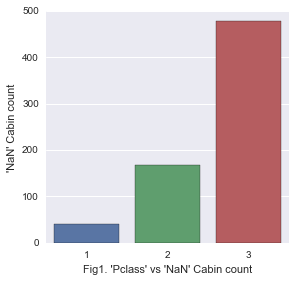

In [808]:
# sbn.factorplot(data=titanic_DF,kind='count',y='Pclass')
cabinNull_DF = pd.DataFrame(titanic_DF[pd.isnull(titanic_DF['Cabin'])])
fig1 = sbn.factorplot(data=cabinNull_DF,kind='count',x='Pclass')
fig1.set_axis_labels("Fig1. 'Pclass' vs 'NaN' Cabin count","'NaN' Cabin count")

So, it is evident from **Fig1.** that most of the unknown cabin information pertains to the 3rd SES (socio-economic status).

The cabin numbers are a combination of an alphabet followed by one or more numbers.  To make it simpler to 'bin' the cabins, I'll retrieve the cabin alphabets for each of the valid cabins in the data set (cabinNotNull_DF).

In [809]:
cabinNotNull_DF = pd.DataFrame(titanic_DF[pd.notnull(titanic_DF['Cabin'])])
cabinTypes = []
for cabin in cabinNotNull_DF['Cabin']:
    cabinTypes.append(cabin[0])
cabinNotNull_DF['CabinType'] = cabinTypes
pd.value_counts(cabinNotNull_DF['CabinType'].values)

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
dtype: int64

**Hmm, there seems to be an odd cabin of type 'T' (perhaps due to a clerical data entry?).  I'll ignore that row for now.**

In [810]:
cabinNotNull_DF = cabinNotNull_DF[cabinNotNull_DF['CabinType'] != 'T']
pd.value_counts(cabinNotNull_DF['CabinType'].values)

C    59
B    47
D    33
E    32
A    15
F    13
G     4
dtype: int64

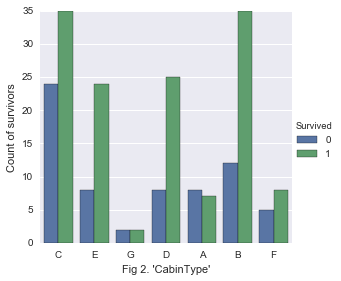

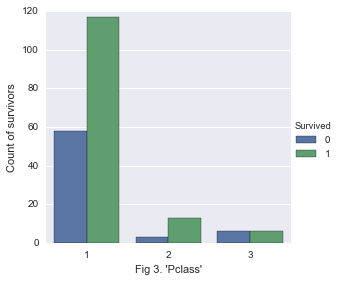

In [811]:
fig2 = sbn.factorplot(data=cabinNotNull_DF,kind='count',hue='Survived',x='CabinType',legend_out=True)
fig2.set_axis_labels("Fig 2. 'CabinType'",'Count of survivors')
fig3 = sbn.factorplot(data=cabinNotNull_DF,kind='count',hue='Survived',x='Pclass',legend_out=True)
fig3.set_axis_labels("Fig 3. 'Pclass'",'Count of survivors')

So, based on **Fig 2.** and **Fig 3.**, we can see that Cabin and SES are certainly good indicators of survivors.  So, I choose to keep **'CabinType'** and **'Pclass'** as potential indicators of survival rate and continue the explorartory analysis.

# **Question (3) How does the demography data (Gender, Family) look?**

Now, I'll look at whether 'Gender' in the cabinNotNull_DF data set is a good indicator of survival and compare that with 'Gender' vs. 'Survived' in the original (titanic_DF) data set.

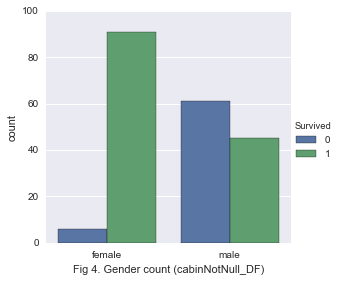

In [812]:
fig4 = sbn.factorplot(data=cabinNotNull_DF,kind='count',x='Sex',hue='Survived')
fig4.set_axis_labels("Fig 4. Gender count (cabinNotNull_DF)")

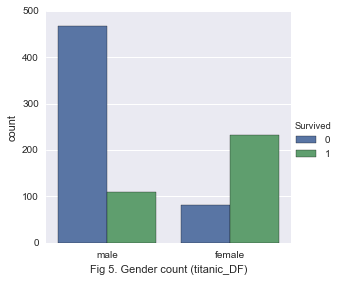

In [813]:
fig5 = sbn.factorplot(data=titanic_DF,kind='count',x='Sex',hue='Survived')
fig5.set_axis_labels("Fig 5. Gender count (titanic_DF)")

**In both cases, gender certainly seems to be a good predictor.  So, I can ignore the rows containing 'Cabin' = NaN, i.e. use cabinNotNull_DF.**  

Next is family data...  

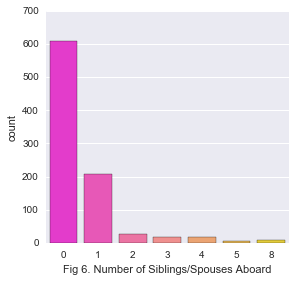

In [814]:
fig6 = sbn.factorplot(data=titanic_DF,kind='count',x='SibSp',palette='spring')
fig6.set_axis_labels("Fig 6. Number of Siblings/Spouses Aboard")

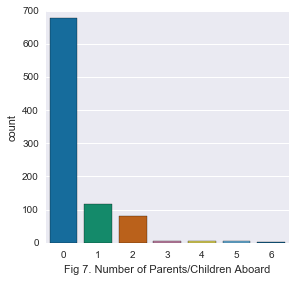

In [815]:
fig7 = sbn.factorplot(data=titanic_DF,kind='count',x='Parch',palette='colorblind')
fig7.set_axis_labels("Fig 7. Number of Parents/Children Aboard")

Ok, so there are more number of people traveling alone, compared to ones that are travelling with family.  For ease of use, I'll bin them into a new column titled **'Alone'**:

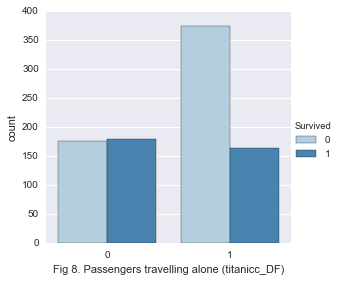

In [816]:
alone = []
for Sib, Fam in zip(titanic_DF['SibSp'], titanic_DF['Parch']):
    if Sib == 0 and Fam ==0 :
        alone.append('1')
    else:
        alone.append('0')
titanic_DF['Alone'] = alone
fig8 = sbn.factorplot(data=titanic_DF,kind='count',x='Alone',hue='Survived',palette='Blues')
fig8.set_axis_labels("Fig 8. Passengers travelling alone (titanicc_DF)")

**That's interesting! Passengers travelling alone seem to have a lower survival rate, compared to ones travelling with family.  So, this seems to be a good exploratory variable for the regression analysis.**  

Now, I'm repeating the above exercise to insert 'Alone' into the cabinNotNull_DF Dataframe.

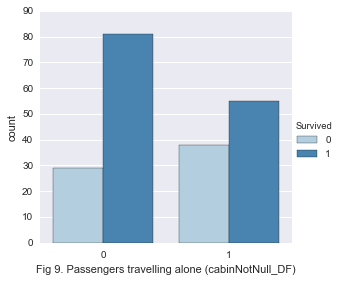

In [817]:
alone = []
for Sib, Fam in zip(cabinNotNull_DF['SibSp'], cabinNotNull_DF['Parch']):
    if Sib == 0 and Fam ==0 :
        alone.append('1')
    else:
        alone.append('0')
cabinNotNull_DF['Alone'] = alone
fig9 = sbn.factorplot(data=cabinNotNull_DF,kind='count',x='Alone',hue='Survived',palette='Blues')
fig9.set_axis_labels("Fig 9. Passengers travelling alone (cabinNotNull_DF)")

This re-inforces the earlier statement.

And finally, the Age factor:

In [818]:
cabinNotNull_DF = cabinNotNull_DF[pd.notnull(cabinNotNull_DF['Age'])]
cabinNotNull_DF = cabinNotNull_DF[pd.notnull(cabinNotNull_DF['Embarked'])]

Here's what the distribution looks like in the cabinNotNull_DF DataFrame:

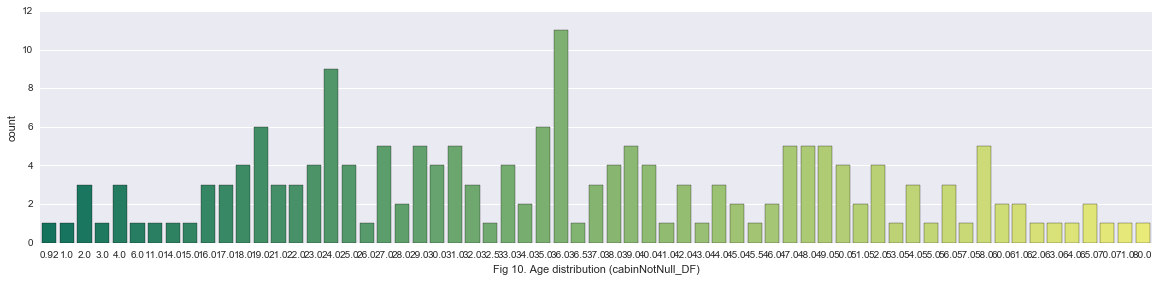

In [819]:
import matplotlib.pyplot as mp
from scipy import stats
import math
fig10 = sbn.factorplot(data=cabinNotNull_DF,kind='count',x='Age',palette='summer',aspect=4)
fig10.set_axis_labels("Fig 10. Age distribution (cabinNotNull_DF)")

Let's see if binning ages helps refine the picture.  Just like the process for 'Cabin', I am going to bin 'Age', and compare the survival rate for those silos.  The binning ranges are evident from the Python code.

In [820]:
def age_to_silos(ageVal):
    if ageVal  < 15 :
        return "Child"
    elif ageVal < 30 :
        return "Twenties"
    elif ageVal < 40 :
        return "Thirties"
    elif ageVal < 50 :
        return "Forties"
    elif ageVal < 60 :
        return "Fifties"
    else:
        return "Seniors"
AgeSilos = []
for ageVal in cabinNotNull_DF['Age']:
    AgeSilos.append(age_to_silos(ageVal))
cabinNotNull_DF['AgeSilos'] = AgeSilos
pd.value_counts(cabinNotNull_DF['AgeSilos'].values)

Twenties    53
Thirties    49
Forties     32
Fifties     24
Child       12
Seniors     12
dtype: int64

Now to visualize the Age silos against the survivors.

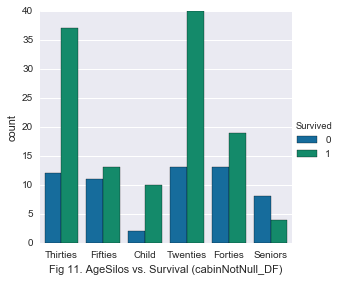

In [821]:
fig11 = sbn.factorplot(data=cabinNotNull_DF,kind='count',x='AgeSilos',palette='colorblind',hue='Survived')
fig11.set_axis_labels("Fig 11. AgeSilos vs. Survival (cabinNotNull_DF)")

Ok, 'Age' seems to be a good predictor of survival rate.

# Question (4) Where did passengers board the Titanic from and does the survival rate depend on the port of embarkment?

In [822]:
pd.value_counts(titanic_DF['Embarked'].values)

S    644
C    168
Q     77
dtype: int64

There are three ports from which passegners boarded the ship.  Let's get a histogram of the survival rate of passengers from each of these ports.

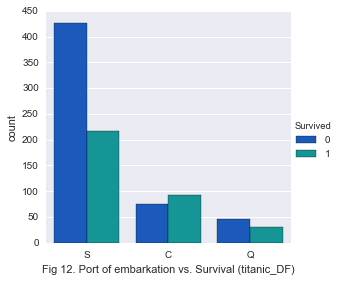

In [823]:
fig12 = sbn.factorplot(data=titanic_DF,kind='count',x='Embarked',palette='winter', hue ='Survived')
fig12.set_axis_labels("Fig 12. Port of embarkation vs. Survival (titanic_DF)")

Now, I'm repeating the above exercise to for the cabinNotNull_DF Dataframe.

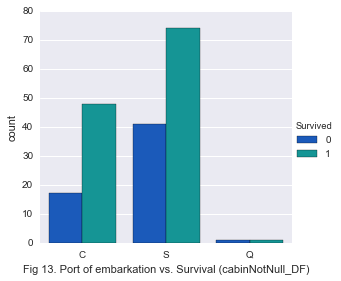

In [824]:
fig13 = sbn.factorplot(data=cabinNotNull_DF,kind='count',x='Embarked',palette='winter', hue ='Survived')
fig13.set_axis_labels("Fig 13. Port of embarkation vs. Survival (cabinNotNull_DF)")

**Ok, this indicates that port of embarkation should be a good predictor of survival rate.**  

I have my four questions answered now.  Time to run a logistic regression on the following explorarory variables:  
Age  
Pclass  
Alone  
Sex  
CabinType  
Embarked  

The target variable is 'Survived'.  

Now, I will create 'Categorical' variables (dummies) for the explanatory variables that are non-numeric, giving them appropriate names so that I can run the regression and interpret the coefficients.  When creating dummies, I need to ensure that I remove one of the dummies from the list, so that I avoid multi-collinearity. 

In [825]:
SexDummies = pd.get_dummies(cabinNotNull_DF['Sex'])
SexDummies = SexDummies.drop('male',axis=1)
AgeDummies = pd.get_dummies(cabinNotNull_DF['AgeSilos'])
AgeDummies = AgeDummies.drop('Forties',axis=1)
CabinTypeDummies = pd.get_dummies(cabinNotNull_DF['CabinType'])
EmbarkedDummies = pd.get_dummies(cabinNotNull_DF['Embarked'])
CabinTypeDummies.columns = ['CabinA','CabinB','CabinC','CabinD','CabinE','CabinF','CabinG']
CabinTypeDummies = CabinTypeDummies.drop('CabinA',axis=1)
EmbarkedDummies.columns = ['EmbarkedC','EmbarkedQ','EmbarkedS']
EmbarkedDummies = EmbarkedDummies.drop('EmbarkedQ',axis=1)

In [826]:
Training_DF = cabinNotNull_DF.drop(['SibSp','Age','PassengerId','Parch','Name','Ticket','Fare','CabinType','Sex','Embarked','Cabin','AgeSilos'],axis=1)
Training_DF = pd.concat([Training_DF,SexDummies,AgeDummies,CabinTypeDummies,EmbarkedDummies],axis=1)
Training_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 1 to 889
Data columns (total 17 columns):
Survived     182 non-null int64
Pclass       182 non-null int64
Alone        182 non-null object
female       182 non-null float64
Child        182 non-null float64
Fifties      182 non-null float64
Seniors      182 non-null float64
Thirties     182 non-null float64
Twenties     182 non-null float64
CabinB       182 non-null float64
CabinC       182 non-null float64
CabinD       182 non-null float64
CabinE       182 non-null float64
CabinF       182 non-null float64
CabinG       182 non-null float64
EmbarkedC    182 non-null float64
EmbarkedS    182 non-null float64
dtypes: float64(14), int64(2), object(1)
memory usage: 25.6+ KB


Ok, now the data frame is in a format that I can run logistic regression on!

Lets separate the target variable from the predictor variables and put the target variable in an 'array' format as required by scikit.

In [899]:
Y = np.ravel(Training_DF['Survived'])
X = Training_DF.drop('Survived',axis=1)

In [900]:
# Machine Learning Imports
from sklearn.linear_model import LogisticRegression
# For evaluating our ML results
from sklearn import metrics

glm_Training = LogisticRegression()
glm_Training.fit(X,Y)
glm_Training.score(X,Y)

0.79670329670329665

So, that's around 80% accuracy rating for the Logitic Regression model.
How does this compare to a simple 'guess' of Survived = 0 for every passenger?
I can get this by comparing the percentage of survivors in the training set, i.e. the mean of the survivors.  Technically, I'm check the "null error rate".  

Now let's use statsmodels and rerun the logistic regression and get a summary of the result:

In [829]:
Y.mean()

0.67582417582417587

This means, if I had simply guessed "Survived = 1" for every pasenger, I would have had 68% accuracy.  So, the logistic model is already doing a much better job than my simplistic 'guess' model.  
I'll now check the coefficients of my logistic model, to see the prediction strengths of the explanatory variables.

In [830]:
glmCoeff_DF = DataFrame([['Intercept',glm_Training.intercept_]])
glmCoeff_DF = glmCoeff_DF.append(DataFrame(zip(X.columns,np.transpose(glm_Training.coef_))),ignore_index=True)
glmCoeff_DF

,0,1
0,Intercept,[0.288242835079]
1,Pclass,[-0.496951642554]
2,Alone,[-0.244311044152]
3,female,[2.55160625809]
4,Child,[1.06746344725]
5,Fifties,[-0.700627345099]
6,Seniors,[-0.670605029192]
7,Thirties,[0.538850565786]
8,Twenties,[0.240566991028]
9,CabinB,[-0.00495490285487]


Since this doesn't provide details of satistical significance of the coefficient, I am going to use statsmodels, rerun the logistic regression and get a summary of the result:

In [831]:
import statsmodels.api as sma

Survived = np.int16(Training_DF['Survived'])
X_array = np.int16(X)
yName = 'Survived'
xName = map(lambda X_columnNames: X_columnNames, X.columns)
logit = sma.Logit(Survived,X_array)
result = logit.fit()
result.summary(yname=yName,xname=xName)

Optimization terminated successfully.
         Current function value: 0.391966
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  182
Model:                          Logit   Df Residuals:                      166
Method:                           MLE   Df Model:                           15
Date:                Sun, 14 Feb 2016   Pseudo R-squ.:                  0.3778
Time:                        22:48:49   Log-Likelihood:                -71.338
converged:                       True   LL-Null:                       -114.66
                                        LLR p-value:                 4.189e-12
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Pclass        -0.4073      0.684     -0.596      0.551        -1.748     0.933
Alone         -0.4455      0.484     -0.920      0.357        -1.394     0.503
female         3.7061      0.644      5.757      0.000         2.444     4.968
Child          2.1074      1.116      1.888      0.059        -0.080     4.295
Fifties       -1.2903      0.759     -1.699      0.089        -2.778     0.198
Seniors       -1.0725      0.922     -1.163      0.245        -2.880     0.735
Thirties       0.6066      0.634      0.957      0.338        -0.635     1.849
Twenties       0.3034      0.660      0.460      0.646        -0.990     1.597
CabinB        -0.7210      0.824     -0.875      0.382        -2.336     0.894
CabinC        -1.5866      0.825     -1.922      0.055        -3.204     0.031
CabinD        -0.4189      0.895     -0.468      0.640        -2.174     1.336
CabinE         0.3242      0.903      0.359      0.720        -1.446     2.094
CabinF        -0.8374      1.511     -0.554      0.579        -3.799     2.124
CabinG        -4.3853      2.154     -2.036      0.042        -8.608    -0.163
EmbarkedC      1.3995      1.041      1.345      0.179        -0.640     3.439
EmbarkedS      0.6958      1.036      0.671      0.502        -1.336     2.727
==============================================================================
"""

Right off the bat, we can see that the p-values for some of the explanatory variables, is **> 0.05**.  So, these variables are **statistically not significant** at the significance level of **$\alpha$ = 0.05**.  Here are those variables, which I am going to remove from my regression model and re-run the logistic regression:  
Pclass  
Alone  
Child  
Fifties  
Seniors  
Thirties  
Twenties  
CabinB  
CabinD  
CabinE  
CabinF  
EmbarkedC  
EmbarkedS  

Hmm, that's an awful lot of variables that I need to throw away.  So, I am going to take the original DataFrame and throw away the relevant variables.

Meanwhile, I noticed that there are quite a few male passengers who embarked from either S or C ports and seemed to have survived.  Here is the visualization of this:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 14 columns):
PassengerId          889 non-null int64
Survived             889 non-null int64
Pclass               889 non-null int64
Name                 889 non-null object
Sex                  889 non-null object
Age                  712 non-null float64
SibSp                889 non-null int64
Parch                889 non-null int64
Ticket               889 non-null object
Fare                 889 non-null float64
Cabin                202 non-null object
Embarked             889 non-null object
maleEmbarkedPortC    889 non-null int64
maleEmbarkedPortS    889 non-null int64
dtypes: float64(2), int64(7), object(5)
memory usage: 104.2+ KB


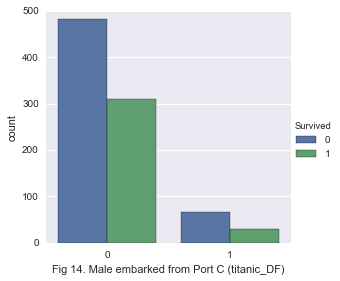

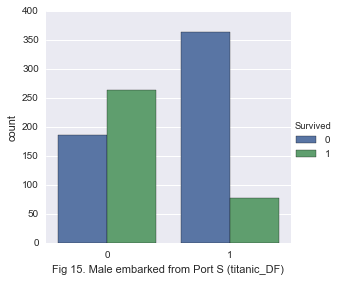

In [832]:
titanic_DF = pd.read_csv("train.csv")
titanic_DF = titanic_DF[pd.notnull(titanic_DF['Embarked'])]
def interactTerms((sexVal, portVal)):
    if sexVal == True & portVal == True :
        return 1
    else:
        return 0
interactTermList = []
for (gender, embarkPortC) in np.int64(zip(titanic_DF['Sex'] == 'male',titanic_DF['Embarked'] == 'C')):
    interactTermList.append(interactTerms((gender, embarkPortC)))
titanic_DF['maleEmbarkedPortC'] = interactTermList
interactTermList = []
for (gender, embarkPortS) in np.int64(zip(titanic_DF['Sex'] == 'male',titanic_DF['Embarked'] == 'S')):
    interactTermList.append(interactTerms((gender, embarkPortS)))
titanic_DF['maleEmbarkedPortS'] = interactTermList
fig14 = sbn.factorplot(data=titanic_DF,kind="count",x="maleEmbarkedPortC",hue='Survived')
fig14.set_axis_labels("Fig 14. Male embarked from Port C (titanic_DF)")
fig15 = sbn.factorplot(data=titanic_DF,kind="count",x="maleEmbarkedPortS",hue='Survived')
fig15.set_axis_labels("Fig 15. Male embarked from Port S (titanic_DF)")
titanic_DF.info()

This brings into the picture **interaction terms**. Before removing the variables identified as statistically not significant from the previous regression run, I would like to create the relevant interaction terms, after which I would like to test my hypothesis of adding males who embarked from either S or C ports into the mix.  Of course, I will remove the above-mentioned variables after I have created the interaction terms.

In [896]:
Xmod_DF = titanic_DF.drop(['PassengerId', 'Pclass','Name','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked'],axis=1)
SexDummies = pd.get_dummies(Xmod_DF['Sex'])
SexDummies = SexDummies.drop('male',axis=1)
Xmod_DF = pd.concat([Xmod_DF,SexDummies],axis=1)
Xmod_DF = Xmod_DF.drop('Sex',axis=1)
Xmod_DF['female'] = np.int64(Xmod_DF['female'])

In [897]:
Survived = np.int16(Xmod_DF['Survived'])
Xmod_DF = Xmod_DF.drop(['Survived'],axis=1)
X_array = np.int16(Xmod_DF)
yName = 'Survived'
xName = map(lambda X_columnNames: X_columnNames, Xmod_DF.columns)
logit = sma.Logit(Survived,X_array)
regressionResult = logit.fit()
regressionResult.summary(yname=yName,xname=xName)

Optimization terminated successfully.
         Current function value: 0.528423
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  889
Model:                          Logit   Df Residuals:                      886
Method:                           MLE   Df Model:                            2
Date:                Sun, 14 Feb 2016   Pseudo R-squ.:                  0.2057
Time:                        23:11:21   Log-Likelihood:                -469.77
converged:                       True   LL-Null:                       -591.41
                                        LLR p-value:                 1.487e-53
=====================================================================================
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
maleEmbarkedPortC    -0.8224      0.223     -3.691      0.000        -1.259    -0.386
maleEmbarkedPortS    -1.5533      0.125    -12.384      0.000        -1.799    -1.307
female                1.0480      0.129      8.116      0.000         0.795     1.301
=====================================================================================
"""

And as expected, all three variables are statistically significant, even at $\alpha$ = 0.01 level.  

Ok, now I'm going to run this model on the test data set that has been provided.  But, I will need to "clean up" the **test data set** and put it in a format similar to the **training data set**, for my model to work properly.  These steps are a repeat of what was done on the training data set:

In [916]:
titanic_test_DF = pd.read_csv("test.csv")
titanic_test_DF = titanic_test_DF[pd.notnull(titanic_test_DF['Embarked'])]
titanic_test_DF = titanic_test_DF[pd.notnull(titanic_test_DF['Sex'])]
def interactTerms((sexVal, portVal)):
    if sexVal == True & portVal == True :
        return 1
    else:
        return 0
interactTermList = []
for (gender, embarkPortC) in np.int64(zip(titanic_test_DF['Sex'] == 'male',titanic_test_DF['Embarked'] == 'C')):
    interactTermList.append(interactTerms((gender, embarkPortC)))
titanic_test_DF['maleEmbarkedPortC'] = interactTermList
interactTermList = []
for (gender, embarkPortS) in np.int64(zip(titanic_test_DF['Sex'] == 'male',titanic_test_DF['Embarked'] == 'S')):
    interactTermList.append(interactTerms((gender, embarkPortS)))
titanic_test_DF['maleEmbarkedPortS'] = interactTermList
SexDummies = pd.get_dummies(titanic_test_DF['Sex'])
SexDummies = SexDummies.drop('male',axis=1)
Xmod_test_DF = titanic_test_DF.drop(['PassengerId', 'Pclass','Name','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked'],axis=1)
SexDummies = pd.get_dummies(Xmod_test_DF['Sex'])
SexDummies = SexDummies.drop('male',axis=1)
Xmod_test_DF = pd.concat([Xmod_test_DF,SexDummies],axis=1)
Xmod_test_DF = Xmod_test_DF.drop('Sex',axis=1)
Xmod_test_DF['female'] = np.int64(Xmod_test_DF['female'])
X_test_array = np.int16(Xmod_test_DF)
glm_Training = LogisticRegression()
glm_Training.fit(Xmod_DF,Survived)
glm_Training.score(Xmod_DF,Survived)

0.78627671541057365

In [917]:
predictedSurvival = glm_Training.predict(X_test_array)
predictedSurvival.mean()

0.36363636363636365

# Predicting with sklearn library

In [922]:
predicted_DF1 = pd.DataFrame(glm_Training.predict(X_test_array),columns=['Survived'])
titanic_test_DF.index=xrange(len(titanic_test_DF))
predicted_DF1.index=xrange(len(predicted_DF1))
result_DF1 = pd.concat([titanic_test_DF,predicted_DF1],axis=1)
result_DF1['Survived'].mean()

0.36363636363636365

# Predicting with statsmodels.api

In [923]:
predicted_DF2 = pd.DataFrame(np.int16(np.round(regressionResult.predict(X_test_array))),columns=['Survived'])

In [926]:
result_DF2 = pd.concat([titanic_test_DF,predicted_DF2],axis=1)
result_DF2['Survived'].mean()

0.36363636363636365

In [928]:
result_DF2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 14 columns):
PassengerId          418 non-null int64
Pclass               418 non-null int64
Name                 418 non-null object
Sex                  418 non-null object
Age                  332 non-null float64
SibSp                418 non-null int64
Parch                418 non-null int64
Ticket               418 non-null object
Fare                 417 non-null float64
Cabin                91 non-null object
Embarked             418 non-null object
maleEmbarkedPortC    418 non-null int64
maleEmbarkedPortS    418 non-null int64
Survived             418 non-null int16
dtypes: float64(2), int16(1), int64(6), object(5)
memory usage: 46.5+ KB
